In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 19.7 MB/s eta 0:00:00


In [3]:
data_대출사기형 = pd.read_csv('/content/drive/MyDrive/2024 캡스톤 프로젝트/Ai/row/fishing/대출사기형.csv')
data_수사기관사칭형 = pd.read_csv('/content/drive/MyDrive/2024 캡스톤 프로젝트/Ai/row/fishing/수사기관사칭형.csv')

In [4]:
data_대출사기형.head()

,Unnamed: 0,내용
0,0,"['여보세요', '네 님', '예 예', '어저께 통화했던 최영환입니다', '아..."
1,1,"['여보세요', '안녕하세요', '고객님 김종현 대리입니다', '아네 대리님', '..."
2,2,"['네 여보세요?', '여보세요', '네 ㅇㅇ 맞으신가요?', '네네', '네 안녕..."
3,3,"['네', '네 여보세요', '뭐 어디세요?', '아 네 안녕하세요', '저희 그 ..."
4,4,"['여보세요', '네 님', '예 예', '어저께 통화했던 최영환입니다', '아..."


In [5]:
data_수사기관사칭형.head()

,Unnamed: 0,내용
0,0,"['아 서울 중앙 지검 첨단 범죄 수사 일부 이희나 수사관입니다.', '본 사건 조..."
1,1,"['여보세요', '여보세요 OOO씨 혹시 맞습니까?', '네', '저는 서울 중앙 ..."
2,2,"['여보세요', '네', '네 안녕하십니까.', '혹시 OOO 핸드폰 맞으십니까?'..."
3,3,"['수고하십니다.', '여기는 서울 중앙 지검이고요', '네', '저는 1,000만..."
4,4,"['어 이름은 김호철이고 태어난 곳은 전라도 광주, 올해로 사십세된 남성에 농협 은..."


In [6]:
data_대출사기형.drop(columns=['Unnamed: 0'],inplace=True)
data_수사기관사칭형.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
data_split_대출사기형=pd.DataFrame(data_대출사기형['내용'].str.split(',').tolist())
data_split_수사기관사칭형=pd.DataFrame(data_수사기관사칭형['내용'].str.split(',').tolist())

In [8]:
import pandas as pd
from konlpy.tag import Okt
from gensim import corpora, models
import gensim

def preprocess_text(text):
    if text is None:  # None 값을 확인
        return []
    okt = Okt()
    tokens = okt.nouns(text)  # 단어 추출
    tokens = [token for token in tokens if len(token) > 1]  # 한 글자 단어 제외
    return tokens

# 데이터 전처리
processed_data = [preprocess_text(' '.join([str(item) if item is not None else '' for item in row])) for index, row in data_split_대출사기형.iterrows()]

# 사전 생성
dictionary = corpora.Dictionary(processed_data)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)  # 필터링으로 빈도가 낮거나 높은 단어 제외

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in processed_data]

최적의 토픽 수: 8, 최대 혼잡도 점수: 0.4877453909306756


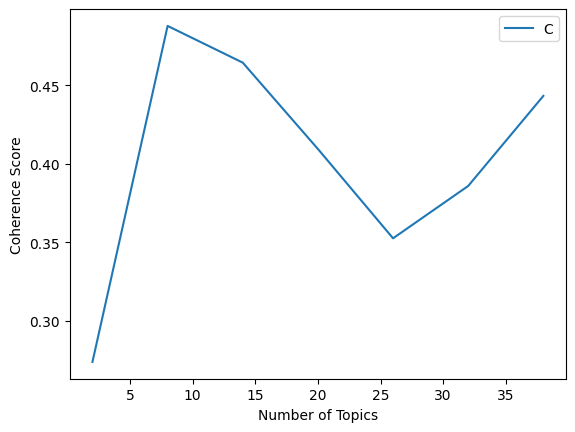

In [9]:
from gensim.models.coherencemodel import CoherenceModel

# 함수: 혼잡도에 기반한 최적의 토픽 수 찾기
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# 혼잡도 계산
start, limit, step = 2, 40, 6
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

# 최적의 토픽 수와 해당 혼잡도 점수를 출력
max_coherence_val = max(coherence_values)
optimal_model_index = coherence_values.index(max_coherence_val)
optimal_num_topics = range(start, limit, step)[optimal_model_index]

print(f"최적의 토픽 수: {optimal_num_topics}, 최대 혼잡도 점수: {max_coherence_val}")

# 혼잡도 점수를 그래프로 그리기
import matplotlib.pyplot as plt

plt.plot(range(start, limit, step), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Value"), loc='best')

plt.show()

In [11]:
# LDA 모델 학습
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=8,  # 추출하고 싶은 토픽의 수
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 토픽과 그에 해당하는 단어들 출력
topics = lda_model.print_topics(num_words=5)  # 각 토픽별 상위 5개 단어
for topic in topics:
    print(topic)

(0, '0.018*"금리" + 0.017*"상환" + 0.017*"대출" + 0.016*"처리" + 0.012*"위임"')
(1, '0.006*"상환" + 0.006*"처리" + 0.006*"위임" + 0.006*"경우" + 0.006*"대출"')
(2, '0.009*"처리" + 0.008*"상환" + 0.008*"혹시" + 0.008*"위임" + 0.008*"토토"')
(3, '0.032*"처리" + 0.027*"상환" + 0.027*"대출" + 0.025*"위임" + 0.022*"경우"')
(4, '0.135*"상환" + 0.077*"센터" + 0.077*"대리" + 0.058*"확인" + 0.039*"서류"')
(5, '0.013*"처리" + 0.013*"대출" + 0.012*"위임" + 0.012*"진행" + 0.010*"경우"')
(6, '0.126*"이용" + 0.084*"금리" + 0.063*"상품" + 0.063*"한번" + 0.042*"현재"')
(7, '0.086*"혹시" + 0.086*"토토" + 0.058*"가입" + 0.058*"사장" + 0.058*"사이트"')


In [13]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.4 MB/s eta 0:00:00


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# pyLDAvis를 사용하여 LDA 모델 시각화
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# HTML 파일로 시각화 저장
pyLDAvis.save_html(vis, 'lda_대출사기형.html')

In [15]:
import pandas as pd
from konlpy.tag import Okt
from gensim import corpora, models
import gensim

def preprocess_text(text):
    if text is None:  # None 값을 확인
        return []
    okt = Okt()
    tokens = okt.nouns(text)  # 단어 추출
    tokens = [token for token in tokens if len(token) > 1]  # 한 글자 단어 제외
    return tokens

# 데이터 전처리
processed_data = [preprocess_text(' '.join([str(item) if item is not None else '' for item in row])) for index, row in data_split_수사기관사칭형.iterrows()]

# 사전 생성
dictionary = corpora.Dictionary(processed_data)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)  # 필터링으로 빈도가 낮거나 높은 단어 제외

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in processed_data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


최적의 토픽 수: 8, 최대 혼잡도 점수: 0.3012028606240074


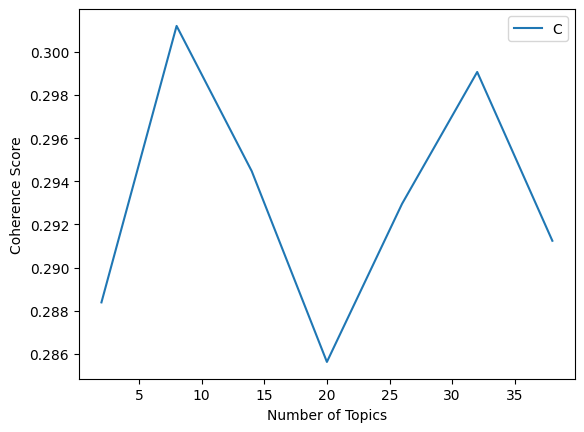

In [17]:
from gensim.models.coherencemodel import CoherenceModel

# 함수: 혼잡도에 기반한 최적의 토픽 수 찾기
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# 혼잡도 계산
start, limit, step = 2, 40, 6
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

# 최적의 토픽 수와 해당 혼잡도 점수를 출력
max_coherence_val = max(coherence_values)
optimal_model_index = coherence_values.index(max_coherence_val)
optimal_num_topics = range(start, limit, step)[optimal_model_index]

print(f"최적의 토픽 수: {optimal_num_topics}, 최대 혼잡도 점수: {max_coherence_val}")

# 혼잡도 점수를 그래프로 그리기
import matplotlib.pyplot as plt

plt.plot(range(start, limit, step), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Value"), loc='best')
plt.show()

In [18]:
# LDA 모델 학습
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=8,  # 추출하고 싶은 토픽의 수
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 토픽과 그에 해당하는 단어들 출력
topics = lda_model.print_topics(num_words=5)  # 각 토픽별 상위 5개 단어
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.049*"만약" + 0.035*"거래" + 0.030*"농협" + 0.029*"기범" + 0.027*"자체"')
(1, '0.062*"농협" + 0.049*"거래" + 0.044*"사용" + 0.029*"건가" + 0.027*"중앙"')
(2, '0.076*"검사" + 0.057*"얘기" + 0.052*"이동" + 0.049*"은행권" + 0.026*"잠시"')
(3, '0.074*"카드" + 0.062*"사용" + 0.050*"입출금" + 0.047*"진술" + 0.041*"농협"')
(4, '0.037*"녹취" + 0.036*"진술" + 0.028*"도용" + 0.020*"가요" + 0.020*"현재"')
(5, '0.045*"피해" + 0.029*"얘기" + 0.026*"시간" + 0.025*"검사" + 0.021*"금액"')
(6, '0.050*"사용" + 0.030*"농협" + 0.028*"한번" + 0.024*"카드" + 0.022*"피해"')
(7, '0.069*"다음" + 0.054*"감독" + 0.052*"직원" + 0.031*"보안" + 0.027*"등록"')


In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# pyLDAvis를 사용하여 LDA 모델 시각화
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# HTML 파일로 시각화 저장
pyLDAvis.save_html(vis, 'lda_수사기관사칭형.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
